In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim
from dataclasses import dataclass
from typing import List, Tuple, Dict

In [31]:
from biasvariance_toolkit import estimate_bias_variance_mse

In [32]:
import sys
print(sys.executable)

E:\conda_packages\dis_env\python.exe


In [33]:
def generate_sinusoid_data(num_samples:int,noise_scale:float=0.3):
    X = np.linspace(-1,1,num_samples).reshape(-1, 1)
    y_true = np.sin(2 * np.pi * X)                       # shape: (num_samples, 1)
    noise = np.random.normal(0, noise_scale, size=(num_samples, 1))#random gaussian noise
    y = y_true + noise
    return X,y

In [34]:
class MLP(nn.Module):
    def __init__(self,input_dim,width,depth,act=nn.ReLU,batchnorm=False,residual=False,dropout_p=0.0,out_dim=1):
        super().__init__()
        self.depth = depth
        self.residual = residual
        self.batchnorm=batchnorm
        layers = []
        last = input_dim
        for d in range(depth):
            layers.append(nn.Linear(last,width))
            if batchnorm:
                layers.append(nn.BatchNorm1d(width))
            layers.append(act())
            if dropout_p>0:
                layers.append(nn.Dropout(dropout_p))
            last = width
        self.feature = nn.Sequential(*layers) if layers else nn.Identity()
        self.proj = nn.Linear(last, out_dim)

        # If using residuals with depth>0, define a projection for skip when dims mismatch
        if residual and depth > 0:
            self.skip_in = nn.Linear(input_dim, width) if input_dim != width else nn.Identity()

    def forward(self, x):
        # x: (N,1)
        if self.depth == 0:
            return self.proj(x)

        h = x
        if self.residual:
            # first block with skip from input
            h1 = self.feature[0](h)  # first Linear
            i = 1
            if self.batchnorm:
                h1 = self.feature[i](h1); i += 1
            h1 = self.feature[i](h1); i += 1  # activation
            if isinstance(self.feature[i] if i < len(self.feature) else None, nn.Dropout):
                h1 = self.feature[i](h1); i += 1

            # after first block, we have width dims
            h = h1 + self.skip_in(x)  # residual add

            # process remaining blocks (groups of Linear-(BN)-Act-OptionalDropout)
            while i < len(self.feature):
                lin = self.feature[i]; i += 1
                h_new = lin(h)
                if self.batchnorm:
                    h_new = self.feature[i](h_new); i += 1
                h_new = self.feature[i](h_new); i += 1
                if i < len(self.feature) and isinstance(self.feature[i], nn.Dropout):
                    h_new = self.feature[i](h_new); i += 1
                h = h + h_new  # residual within width
        else:
            h = self.feature(h)

        out = self.proj(h)
        return out

In [35]:
@dataclass
class TrainConfig:
    batch_size: int = 128
    epochs: int = 300
    lr: float = 3e-3
    weight_decay: float = 1e-3
    grad_clip: float = 1.0
    early_stop_patience: int = 30
    device: str = "cpu"
    seed: int = 42

In [36]:
NUM_TRAIN_SAMPLES = 5000
NUM_TEST_SAMPLES = 1000
BOOTSTRAP_NUMS = 30
MAX_EPOCHS = 500
PATIENCE = 500
LEARNING_RATE=0.001

In [37]:
depths = [1, 4, 8, 16, 24, 32,40]

In [38]:
X_train,y_train = generate_sinusoid_data(num_samples=NUM_TRAIN_SAMPLES)
X_test,y_test = generate_sinusoid_data(num_samples=NUM_TEST_SAMPLES,noise_scale=0)

In [ ]:
hidden_units=256
depth_results= []
for d in depths:
    print(f"\n*** Running experiment for network with {d} depth***")
    bias_sq, variance, total_error,error_sum,avg_train_loss,test_loss = estimate_bias_variance_mse(
            model_class=MLP,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            loss_fn=nn.MSELoss(),
            model_kwargs={'input_dim':X_train.shape[1],"width":128,'depth':d,'residual':True},
            num_models=30,
            max_epochs=MAX_EPOCHS,
            patience=PATIENCE,
            lr=LEARNING_RATE,
            batch_size=128
        )
    depth_results.append({
            'depth': d,
            'bias_sq': bias_sq,
            'variance': variance,
            'total_error': total_error,
            'error_sum': error_sum,
            'avg_train_loss':avg_train_loss,
            'test_loss':test_loss
        })



*** Running experiment for network with 1 depth***

--- Training Model 1/30 ---

--- Training Model 2/30 ---

--- Training Model 3/30 ---

--- Training Model 4/30 ---

--- Training Model 5/30 ---

--- Training Model 6/30 ---


In [ ]:
# bias_values = [res['bias_sq'] for res in depth_results]
# variance_values = [res['variance'] for res in depth_results]
# error_values = [res['total_error'] for res in depth_results]
# bias_plus_variance = [res['error_sum'] for res in depth_results]
    
# plt.figure(figsize=(10, 6))
# plt.plot(depths, bias_values, marker='o', label='Bias')
# plt.plot(depths, variance_values, marker='s', label='Variance')
# plt.plot(depths, error_values, marker='p', label='total error')
# plt.plot(depths, bias_plus_variance, marker='p', label='bias + variance')

    
# plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression with batchnorm and residuals')
# plt.legend()
plt.grid(True)
plt.tight_layout()

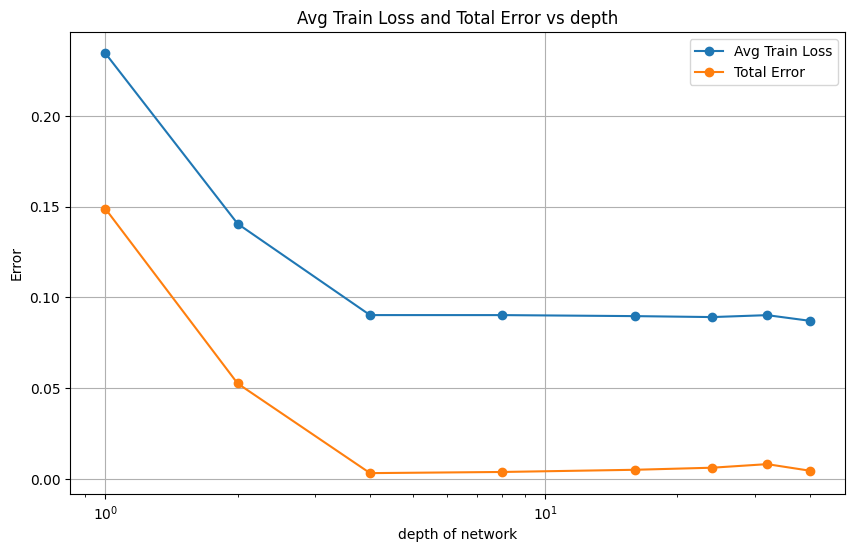

In [54]:
test_loss = [r['total_error'] for r in depth_results]
avg_train_loss = [r['avg_train_loss'] for r in depth_results]

plt.figure(figsize=(10, 6))
plt.plot(depths, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(depths, test_loss, marker='o', label='Total Error')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('depth of network')
plt.ylabel('Error')
plt.title('Avg Train Loss and Total Error vs depth')
plt.legend()
plt.grid(True)
plt.show()
